In [19]:
%%writefile config.yaml

data_path: H:/dev/mit/UNCWave/datasetfiles/FlatVel_A
model: 
    name: UNet
    unet_params:
        init_features: 32
        depth: 5
read_weights: null
batch_size: 8  #64
print_freq: 50 #500
max_epochs: 2 #20
es_epochs: 2 #4
seed: 42
valid_frac: 36
train_frac: 5
optimizer:
    lr: 0.0001
    weight_decay: 0.001
scheduler:
    params:
        factor: 0.316227766
        patience: 1

Overwriting config.yaml


In [20]:

import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

def inputs_files_to_output_files(input_files):
    return [
        # Path(str(f).replace('seis', 'vel').replace('data', 'model'))
        f.parent.parent / "model" / f.name.replace("data", "model").replace("seis", "vel")
        for f in input_files
    ]


def get_train_files(data_path):

    data_dir = Path(data_path) / "data"
    model_dir = Path(data_path)/ "model"

    input_files = sorted(data_dir.glob("*.npy"))
    output_files = sorted(model_dir.glob("*.npy"))

    assert len(input_files) == len(output_files), "Mismatch between input and output files"

    # print("get_train_files/input files", input_files)
    # print("get_train_files/output files", output_files)

    return input_files, output_files

    # all_inputs = [
    #     f
    #     for f in
    #     Path(data_path).rglob('*.npy')
    #     if ('seis' in f.stem) or ('data' in f.stem)
    # ]

    # all_outputs = inputs_files_to_output_files(all_inputs)

    # assert all(f.exists() for f in all_outputs)

    # return all_inputs, all_outputs


class SeismicDataset(Dataset):
    def __init__(self, inputs_files, output_files, n_examples_per_file=500):
        assert len(inputs_files) == len(output_files)
        self.inputs_files = inputs_files
        self.output_files = output_files
        self.n_examples_per_file = n_examples_per_file

    def __len__(self):
        return len(self.inputs_files) * self.n_examples_per_file

    def __getitem__(self, idx):
        # Calculate file offset and sample offset within file
        file_idx = idx // self.n_examples_per_file
        sample_idx = idx % self.n_examples_per_file

        X = np.load(self.inputs_files[file_idx], mmap_mode='r')
        y = np.load(self.output_files[file_idx], mmap_mode='r')

        if sample_idx >= X.shape[0]:
            print(f"Loaded {self.inputs_files[file_idx]}: shape {X.shape}")
            raise IndexError(f"Sample index {sample_idx} out of bounds for file {self.inputs_files[file_idx]} with shape {X.shape}")


        try:
            return X[sample_idx].copy(), y[sample_idx].copy()
        finally:
            del X, y


class TestDataset(Dataset):
    def __init__(self, test_files):
        self.test_files = test_files


    def __len__(self):
        return len(self.test_files)


    def __getitem__(self, i):
        test_file = self.test_files[i]

        return np.load(test_file), test_file.stem

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ResidualDoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2 + Residual Connection"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolution layer
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to handle potential channel mismatch
        if in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            # Projection shortcut: 1x1 conv + BN to match output channels
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x  # Store the input for the residual connection

        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second conv block (without final ReLU yet)
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply shortcut to the identity path
        identity_mapped = self.shortcut(identity)

        # Add the residual connection
        out += identity_mapped

        # Apply final ReLU
        out = self.relu(out)
        return out


class Up(nn.Module):
    """Upscaling then ResidualDoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
            # Input to ResidualDoubleConv = channels from upsampled layer below + channels from skip connection
            # Output of ResidualDoubleConv = desired output channels for this decoder stage
            self.conv = ResidualDoubleConv(in_channels + out_channels, out_channels) # Use ResidualDoubleConv

        else: # Using ConvTranspose2d
            # ConvTranspose halves the channels: in_channels -> in_channels // 2
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # Input channels to ResidualDoubleConv
            conv_in_channels = in_channels // 2 # Channels after ConvTranspose
            skip_channels = out_channels       # Channels from skip connection
            total_in_channels = conv_in_channels + skip_channels
            self.conv = ResidualDoubleConv(total_in_channels, out_channels) # Use ResidualDoubleConv

    def forward(self, x1, x2):
        # x1 is the feature map from the layer below (needs upsampling)
        # x2 is the skip connection from the corresponding encoder layer
        x1 = self.up(x1)

        # Pad x1 if its dimensions don't match x2 after upsampling
        # Input is CHW
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        # Pad format: (padding_left, padding_right, padding_top, padding_bottom)
        x1 = F.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """1x1 Convolution for the output layer"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """U-Net architecture implementation with Residual Blocks"""

    def __init__(
        self,
        n_channels=5,
        n_classes=1,
        init_features=32,
        depth=5, # number of pooling layers
        bilinear=True,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.depth = depth

        self.initial_pool = nn.AvgPool2d(kernel_size=(14, 1), stride=(14, 1))

        # --- Encoder ---
        self.encoder_convs = nn.ModuleList() # Store conv blocks
        self.encoder_pools = nn.ModuleList() # Store pool layers

        # Initial conv block (no pooling before it)
        # Use ResidualDoubleConv for the initial convolution block
        self.inc = ResidualDoubleConv(n_channels, init_features)
        self.encoder_convs.append(self.inc)

        current_features = init_features
        for _ in range(depth):
            # Define convolution block for this stage
            conv = ResidualDoubleConv(current_features, current_features * 2)
            # Define pooling layer for this stage
            pool = nn.MaxPool2d(2)
            self.encoder_convs.append(conv)
            self.encoder_pools.append(pool)
            current_features *= 2

        # --- Bottleneck ---
        # Use ResidualDoubleConv for the bottleneck
        self.bottleneck = ResidualDoubleConv(current_features, current_features)

        # --- Decoder ---
        self.decoder_blocks = nn.ModuleList()
        # Input features start from bottleneck output features
        # Output features at each stage are halved
        for _ in range(depth):
            # Up block uses ResidualDoubleConv internally and handles channels
            up_block = Up(current_features, current_features // 2, bilinear)
            self.decoder_blocks.append(up_block)
            current_features //= 2 # Halve features for next Up block input

        # --- Output Layer ---
        # Input features are the output features of the last Up block
        self.outc = OutConv(current_features, n_classes)

    def _pad_or_crop(self, x, target_h=70, target_w=70):
        """Pads or crops input tensor x to target height and width."""
        _, _, h, w = x.shape
        # Pad Height if needed
        if h < target_h:
            pad_top = (target_h - h) // 2
            pad_bottom = target_h - h - pad_top
            x = F.pad(x, (0, 0, pad_top, pad_bottom))  # Pad height only
            h = target_h
        # Pad Width if needed
        if w < target_w:
            pad_left = (target_w - w) // 2
            pad_right = target_w - w - pad_left
            x = F.pad(x, (pad_left, pad_right, 0, 0))  # Pad width only
            w = target_w
        # Crop Height if needed
        if h > target_h:
            crop_top = (h - target_h) // 2
            # Use slicing to crop
            x = x[:, :, crop_top : crop_top + target_h, :]
            h = target_h
        # Crop Width if needed
        if w > target_w:
            crop_left = (w - target_w) // 2
            x = x[:, :, :, crop_left : crop_left + target_w]
            w = target_w
        return x

    def forward(self, x):
        # Initial pooling and resizing
        x_pooled = self.initial_pool(x)
        x_resized = self._pad_or_crop(x_pooled, target_h=70, target_w=70)

        # --- Encoder Path ---
        skip_connections = []
        xi = x_resized

        # Apply initial conv (inc)
        xi = self.encoder_convs[0](xi)
        skip_connections.append(xi) # Store output of inc

        # Apply subsequent encoder convs and pools
        # self.depth is the number of pooling layers
        for i in range(self.depth):
            # Apply conv block for this stage
            xi = self.encoder_convs[i+1](xi)
            # Store skip connection *before* pooling
            skip_connections.append(xi)
            # Apply pooling layer for this stage
            xi = self.encoder_pools[i](xi)

        # Apply bottleneck conv
        xi = self.bottleneck(xi)

        # --- Decoder Path ---
        xu = xi # Start with bottleneck output
        # Iterate through decoder blocks and corresponding skip connections in reverse
        for i, block in enumerate(self.decoder_blocks):
            # Determine the correct skip connection index from the end
            # Example: depth=5. Skips stored: [inc, enc1, enc2, enc3, enc4] (indices 0-4)
            # Decoder 0 (Up(1024, 512)) needs skip 4 (enc4)
            # Decoder 1 (Up(512, 256)) needs skip 3 (enc3) ...
            # Decoder 4 (Up(64, 32)) needs skip 0 (inc)
            skip_index = self.depth - 1 - i
            skip = skip_connections[skip_index]
            xu = block(xu, skip) # Up block combines xu (from below) and skip

        # --- Final Output ---
        logits = self.outc(xu)
        # Apply scaling and offset specific to the problem's target range
        output = logits * 1000.0 + 1500.0
        return output

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def summarize_tensor(tensor):
    # tensor shape: (batch, channels, height, width)
    # Reduce to single scalar: mean over batch, channels, height, width
    return tensor.detach().cpu().mean().item()

def accumulate_and_plot(activations, gradients, threshold=0.97):
    act_values = []
    grad_values = []

    # Accumulate mean values per layer
    for layer_name in activations.keys():
        act_val = summarize_tensor(activations[layer_name])
        grad_val = summarize_tensor(gradients[layer_name])
        act_values.append(act_val)
        grad_values.append(grad_val)

    act_values = np.array(act_values)
    grad_values = np.array(grad_values)

    # Normalize to 0-1 for plotting
    act_norm = (act_values - act_values.min()) / (act_values.max() - act_values.min() + 1e-8)
    grad_norm = (grad_values - grad_values.min()) / (grad_values.max() - grad_values.min() + 1e-8)

    # Apply threshold by clipping
    act_norm = np.clip(act_norm, threshold, 1.0)
    grad_norm = np.clip(grad_norm, threshold, 1.0)

    # Create vertical heatmaps (2D with shape: layers x 1)
    fig, axs = plt.subplots(1, 2, figsize=(4, 8))

    axs[0].imshow(act_norm[:, None], cmap='gray', aspect='auto')
    axs[0].set_title("Activations")
    axs[0].set_yticks(range(len(activations)))
    axs[0].set_yticklabels(list(activations.keys()))
    axs[0].set_xticks([])

    axs[1].imshow(grad_norm[:, None], cmap='gray', aspect='auto')
    axs[1].set_title("Gradients")
    axs[1].set_yticks(range(len(gradients)))
    axs[1].set_yticklabels(list(gradients.keys()))
    axs[1].set_xticks([])

    plt.tight_layout()
    plt.show()

In [25]:

import datetime
import random
import torch
import numpy as np

def format_time(elapsed):
    """Take a time in seconds and return a string hh:mm:ss."""
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def seed_everything(
    seed_value: int
) -> None:
    """
    Controlling a unified seed value for Python, NumPy, and PyTorch (CPU, GPU).

    Parameters:
    ----------
    seed_value : int
        The unified random seed value.
    """
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
    if torch.backends.cudnn.is_available:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [26]:
# hook activations and gradients
activations = {}
gradients = {}

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

def save_gradient(name):
    def hook(module, grad_input, grad_output):
        # grad_output is a tuple (gradients w.r.t. outputs)
        gradients[name] = grad_output[0].detach()
    return hook

In [27]:

import os
import sys
import yaml
from torch.utils.data import DataLoader
from pprint import pprint
import torch
import torch.nn as nn
import numpy as np
import time
from contextlib import nullcontext

## for cpu
amp_ctx = torch.autocast(device_type="cuda") if torch.cuda.is_available() else nullcontext()

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    _, total = torch.cuda.mem_get_info(device=0)
    print(f"GPU memory: {total / 1024**3:.2f}GB")
else:
    print("Running on CPU")

with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)
print()
pprint(config)
if config["data_path"] is None:
    config["data_path"] = os.environ["TMPDIR"]
    print("data_path:", config["data_path"])
print()

seed_everything(config["seed"])

all_inputs, all_outputs = [], []
for i in range(1, 3):
    # all_inputs1, all_outputs1 = get_train_files(config["data_path"]+f"-{i}")
    all_inputs1, all_outputs1 = get_train_files(config["data_path"])
    all_inputs.extend(all_inputs1)
    all_outputs.extend(all_outputs1)
print("Total number of input/output files:", len(all_inputs))

valid_inputs = [all_inputs[i] for i in range(0, len(all_inputs), config["valid_frac"])]
train_inputs = [f for f in all_inputs if not f in valid_inputs]
if config["train_frac"] > 1:
    train_inputs = [train_inputs[i] for i in range(0, len(train_inputs), config["train_frac"])]

print("Number of train files:", len(train_inputs))
print("Number of valid files:", len(valid_inputs))
print()

train_outputs = inputs_files_to_output_files(train_inputs)
valid_outputs = inputs_files_to_output_files(valid_inputs)

dstrain = SeismicDataset(train_inputs, train_outputs)

dltrain = DataLoader(
    dstrain,
    batch_size=config["batch_size"],
    shuffle=True,
    pin_memory=False,
    drop_last=True,
    num_workers=0, #4,
    persistent_workers=False, #True,
)

dsvalid = SeismicDataset(valid_inputs, valid_outputs)
dlvalid = DataLoader(
    dsvalid,
    batch_size=4*config["batch_size"],
    shuffle=False,
    pin_memory=False,
    drop_last=False,
    num_workers=0, #4,
    persistent_workers=False, #True,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(**config["model"]["unet_params"]).to(device)


""" 
HOOK activation and gradient 
"""
# Register forward hooks to save activations
for i, layer in enumerate(model.encoder_convs):
    layer.register_forward_hook(save_activation(f"encoder_conv_{i}"))

# Register backward hooks to save gradients
for i, layer in enumerate(model.encoder_convs):
    layer.register_backward_hook(save_gradient(f"encoder_conv_{i}"))

####  END HOOKING  #######


if config["read_weights"] is not None:
    print("Reading weights from:", config["read_weights"])
    model.load_state_dict(torch.load(config["read_weights"], weights_only=True))

criterion = nn.L1Loss()   #measures the mean absolute error (MAE) between each element in the input x, y
optimizer = torch.optim.AdamW(model.parameters(), **config["optimizer"])  # hparams
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', **config["scheduler"]["params"])

best_val_loss = 10000.0
epochs_wo_improvement = 0
t0 = time.time()  # Measure staring time

parameters_conv = [
    p for name, p in model.named_parameters()
    if p.requires_grad and 'conv' in name and p.ndim == 4
]
ud = []
eps = 1e-8

for epoch in range(1, config["max_epochs"] + 1):

    # Train
    model.train()
    train_losses = []
    for step, (inputs, targets) in enumerate(dltrain):

        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        # with torch.autocast(device_type="cuda"):
        with amp_ctx:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        loss.backward()

        lr = optimizer.param_groups[0]['lr']

        with torch.no_grad():
            ud.append([
                    (lr * (p.grad.std() + eps) / (p.data.std() + eps)).log10().item()
                    if p.grad is not None else float('-inf')
                    for p in parameters_conv
                ])


        optimizer.step()
        train_losses.append(loss.item())

        if step % config["print_freq"] == config["print_freq"] - 1 or step == len(dltrain) - 1:
            trn_loss = np.mean(train_losses)
            t1 = format_time(time.time() - t0)
            if torch.cuda.is_available():
                free, total = torch.cuda.mem_get_info(device=0)
                mem_used = (total - free) / 1024**3
                lr = optimizer.param_groups[-1]['lr']
                print(
                    f"Epoch: {epoch:02d}  Step {step+1}/{len(dltrain)}  Trn Loss: {trn_loss:.2f}  LR: {lr:.2e}  GPU Usage: {mem_used:.2f}GB  Elapsed Time: {t1}",
                    flush=True,
                )
            else:
                lr = optimizer.param_groups[-1]['lr']
                print(
                    f"Epoch: {epoch:02d}  Step {step+1}/{len(dltrain)}  Trn Loss: {trn_loss:.2f}  LR: {lr:.2e}  GPU Usage: On CPU GB  Elapsed Time: {t1}",
                    flush=True,
                )


    # Valid
    model.eval()
    valid_losses = []
    for inputs, targets in dlvalid:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.inference_mode():        
            # with torch.autocast(device_type="cuda"):
            with amp_ctx:
                outputs = model(inputs)

        loss = criterion(outputs, targets)

        valid_losses.append(loss.item())

    t1 = format_time(time.time() - t0)
    trn_loss = np.mean(train_losses)
    val_loss = np.mean(valid_losses)

    if torch.cuda.is_available():
        free, total = torch.cuda.mem_get_info(device=0)
        mem_used = (total - free) / 1024**3

        print(
            f"\nEpoch: {epoch:02d}  Trn Loss: {trn_loss:.2f}  Val Loss: {val_loss:.2f}  GPU Usage: {mem_used:.2f}GB  Elapsed Time: {t1}",
            flush=True,
        )
    else:
        print(
            f"\nEpoch: {epoch:02d}  Trn Loss: {trn_loss:.2f}  Val Loss: {val_loss:.2f}  GPU Usage: CPU GB  Elapsed Time: {t1}",
            flush=True,
        )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_wo_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"\nNew best val_loss: {val_loss:.2f}\n", flush=True)
    else:
        epochs_wo_improvement += 1
        print(f"\nEpochs without improvement: {epochs_wo_improvement}\n", flush=True)

    if epochs_wo_improvement == config["es_epochs"]:
        break

    scheduler.step(val_loss)

GPU: NVIDIA RTX A500 Laptop GPU
GPU memory: 4.00GB

{'batch_size': 8,
 'data_path': 'H:/dev/mit/UNCWave/datasetfiles/FlatVel_A',
 'es_epochs': 2,
 'max_epochs': 2,
 'model': {'name': 'UNet', 'unet_params': {'depth': 5, 'init_features': 32}},
 'optimizer': {'lr': 0.0001, 'weight_decay': 0.001},
 'print_freq': 50,
 'read_weights': None,
 'scheduler': {'params': {'factor': 0.316227766, 'patience': 1}},
 'seed': 42,
 'train_frac': 5,
 'valid_frac': 36}

Total number of input/output files: 0
Number of train files: 0
Number of valid files: 0



ValueError: num_samples should be a positive integer value, but got num_samples=0

#1

Epoch: 01  Step 50/125  Trn Loss: 519.98  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:01:06
Epoch: 01  Step 100/125  Trn Loss: 444.73  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:02:26
Epoch: 01  Step 125/125  Trn Loss: 421.58  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:03:03

Epoch: 01  Trn Loss: 421.58  Val Loss: 329.97  GPU Usage: CPU GB  Elapsed Time: 0:03:47

New best val_loss: 329.97

Epoch: 02  Step 50/125  Trn Loss: 349.99  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:05:06
Epoch: 02  Step 100/125  Trn Loss: 344.51  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:06:18
Epoch: 02  Step 125/125  Trn Loss: 339.54  LR: 1.00e-04  GPU Usage: On CPU GB  Elapsed Time: 0:06:55

Epoch: 02  Trn Loss: 339.54  Val Loss: 341.74  GPU Usage: CPU GB  Elapsed Time: 0:07:34

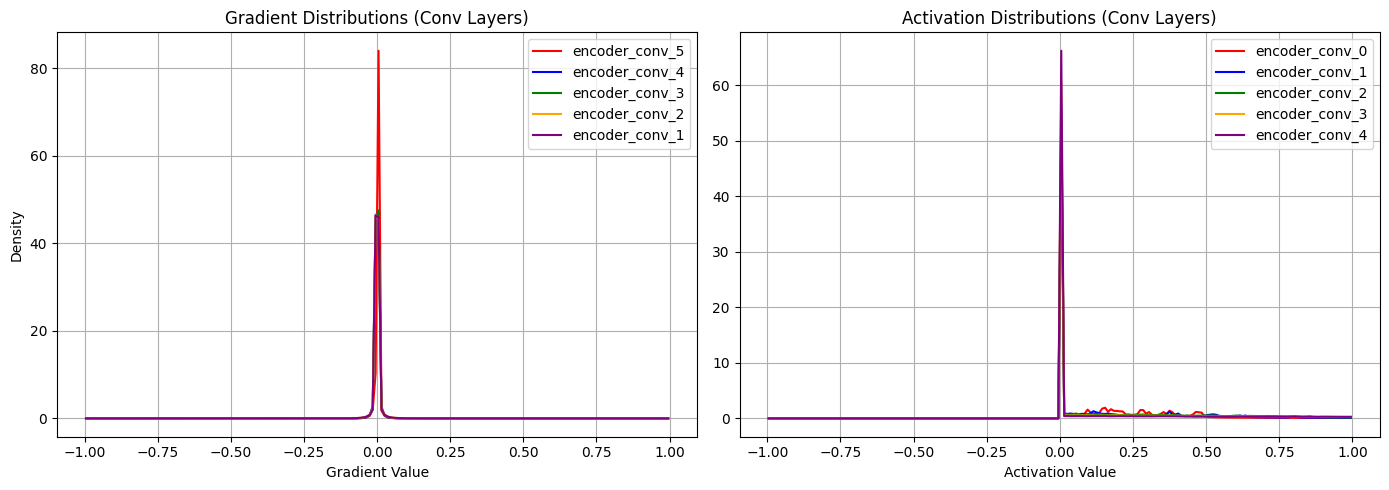

In [105]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # No sharey

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
max_layers = 5
layer_count = 0

# Plot Gradients
for name, gradient in gradients.items():
    if 'conv' in name.lower():
        if layer_count >= max_layers:
            break
        
        flat = gradient.detach().cpu().flatten().numpy()
        hist, bin_edges = np.histogram(flat, bins=200, range=(-1, 1), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axes[0].plot(bin_centers, hist, label=name, color=colors[layer_count % len(colors)])
        layer_count += 1

axes[0].set_title('Gradient Distributions (Conv Layers)')
axes[0].set_xlabel('Gradient Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Reset layer count for activations
layer_count = 0

# Plot Activations
for name, activation in activations.items():
    if 'conv' in name.lower():
        if layer_count >= max_layers:
            break
        
        flat = activation.detach().cpu().flatten().numpy()
        hist, bin_edges = np.histogram(flat, bins=200, range=(-1, 1), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axes[1].plot(bin_centers, hist, label=name, color=colors[layer_count % len(colors)])
        layer_count += 1

axes[1].set_title('Activation Distributions (Conv Layers)')
axes[1].set_xlabel('Activation Value')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

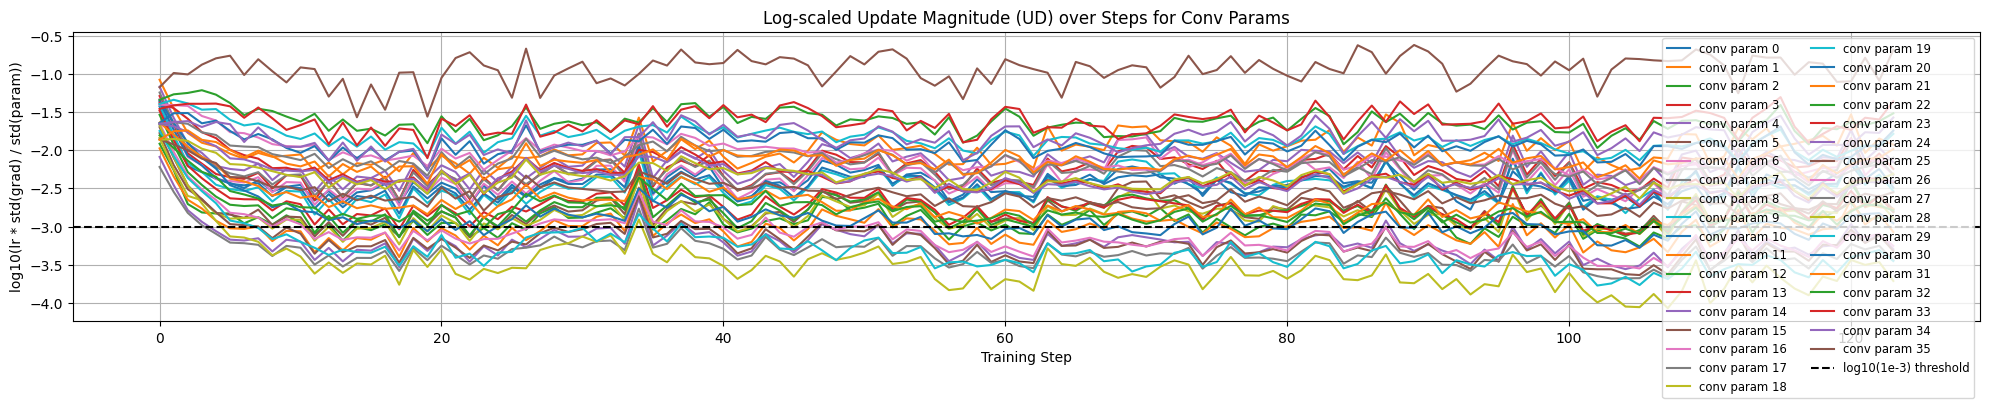

In [106]:
ud_array = np.array(ud)

plt.figure(figsize=(20, 4))

for i in range(ud_array.shape[1]):  # loop over conv params
    y = ud_array[:, i]
    # Skip param if contains any NaN or infinite values
    if np.all(np.isfinite(y)):
        plt.plot(y, label=f'conv param {i}')

plt.axhline(-3, color='k', linestyle='--', label='log10(1e-3) threshold')
plt.title("Log-scaled Update Magnitude (UD) over Steps for Conv Params")
plt.xlabel("Training Step")
plt.ylabel("log10(lr * std(grad) / std(param))")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

import csv
from pathlib import Path
import os

t0 = time.time()

test_files = list(Path(os.path.join(config["data_path"], "test")).glob("*.npy"))
x_cols = [f"x_{i}" for i in range(1, 70, 2)]
fieldnames = ["oid_ypos"] + x_cols
ds = TestDataset(test_files)
dl = DataLoader(ds, batch_size=4*config["batch_size"], num_workers=4, pin_memory=False)

model.load_state_dict(torch.load("best_model.pth", weights_only=True))

model.eval()
with open("submission.csv", "wt", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for inputs, oids_test in dl:
        inputs = inputs.to(device)
        with torch.inference_mode():
            with torch.autocast(device_type="cuda"):
                outputs = model(inputs)

        y_preds = outputs[:, 0].cpu().numpy()

        for y_pred, oid_test in zip(y_preds, oids_test):
            for y_pos in range(70):
                row = dict(zip(x_cols, [y_pred[y_pos, x_pos] for x_pos in range(1, 70, 2)]))
                row["oid_ypos"] = f"{oid_test}_y_{y_pos}"

                writer.writerow(row)

t1 = format_time(time.time() - t0)
print(f"Inference Time: {t1}")